In [1]:
#data format library
import h5py
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import sys
import os
import matplotlib.cm as cm
import pandas as pd
from tqdm.auto import tqdm

plt.rcParams["font.family"] = "Arial"
plt.rc('font', size=13)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title

def bootstrap(l,n_times,confidence_interval=95):
    per=(100-confidence_interval)/2
    new_means=[]
    for i in range(n_times):
        indices=np.random.choice(range(0,len(l)),len(l))
        new_list=[l[idx] for idx in indices]
        new_means.append(ma.mean(new_list,axis=0))
    new_means=ma.vstack(new_means)
    cil=np.zeros(new_means.shape[1])
    ciu=np.zeros(new_means.shape[1])
    for i in range(new_means.shape[1]):
        cil[i]=np.nanpercentile(new_means[:,i].filled(np.nan),per)
        ciu[i]=np.nanpercentile(new_means[:,i].filled(np.nan),100-per)
    cil = ma.masked_array(cil, np.isnan(cil))
    ciu = ma.masked_array(ciu, np.isnan(ciu))
    return ma.mean(l,axis=0),cil,ciu

    
def acf(x, lags=500):
    x = x - x.mean()  # remove mean
    if type(lags) is int:
        lags = range(lags)

    C = ma.zeros((len(lags),))
    sigma2 = x.var()
    for i, l in enumerate(lags):
        if l == 0:
            C[i] = 1
        elif l >= x.shape[0]:
            C[i] = ma.masked
        else:
            x0 = x[:-l].copy()
            x1 = x[l:].copy()
            C[i] = (x0*x1).mean()/sigma2
    return C

In [2]:
import numpy as np
from numba import jit

@jit(nopython=True)
def histogram2d_numba(x, y, bins):
    n_bins = len(bins) - 1
    hist = np.zeros((n_bins, n_bins), dtype=np.float64)
    for i in range(x.size):
        # Find the bin indices
        bin_x = np.searchsorted(bins, x[i], side='right') - 1
        bin_y = np.searchsorted(bins, y[i], side='right') - 1

        if 0 <= bin_x < n_bins and 0 <= bin_y < n_bins:
            hist[bin_x, bin_y] += 1
    return hist

@jit(nopython=True)
def compute_entropy(p):
    # Entropy calculation
    entropy = 0.0
    for i in range(p.shape[0]):
        if p[i]>0:
            entropy-=p[i]*np.log(p[i])
    return entropy

from numba import prange

@jit(nopython=True, parallel=True)
def get_agg_h_numba_parallel(X_w, n_bins=20):
    bins = np.linspace(0, 10, n_bins)
    T = X_w.shape[1]
    agg_t = np.zeros(T)
    agg_r_t = np.zeros(T)
    for t0 in prange(T):
        # Masked filtering and histogram computation
        mask = ~np.isnan(X_w[:, t0, 0])
        X = X_w[mask, t0, :]
        if X.shape[0] == 0:
            agg_t[t0] = np.nan

        freqs = histogram2d_numba(X[:, 0], X[:, 1], bins)
        total = freqs.sum()
        if total > 0:
            p = freqs / total
            h = compute_entropy(p.ravel())
            if h>0:
                agg_t[t0] = 1 / h
            else:
                agg_t[t0] = np.nan
        else:
            agg_t[t0] = np.nan
        freqs = np.ones(mask.sum())
#         print(X.shape,mask.sum())
        p_random = freqs/freqs.sum()
        h_random = compute_entropy(p_random)
        if h_random>0:
            agg_r_t[t0] = 1/h_random
        else:
            agg_r_t[t0] = np.nan
    return agg_t,agg_r_t


In [3]:
f = h5py.File('/Users/ykang/YJ_writing/Evo_Agg_paper/dataset/pharinx_centroids_strain.h5','r')
X_pos = ma.masked_invalid(np.array(f[str(20)]['DL238']['X_pos']))
f.close()
X_pos.shape

(5, 21, 37000, 2)

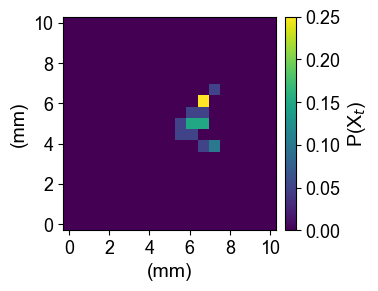

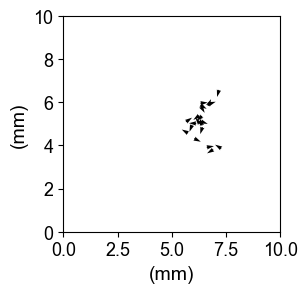

In [4]:
kexp=2 #2 #0
sel = ~np.array([np.all(X_pos[kexp][kw].mask) for kw in range(X_pos[kexp].shape[0])],dtype=bool)
X_w = ma.filled(X_pos[kexp][sel],np.nan)

t0=36000 #1203 #128  #3
mask = ~np.isnan(X_w[:, t0, 0])
X = X_w[mask, t0, :]
bins = np.linspace(0, 10, 20)

prob=histogram2d_numba(X[:, 0], X[:, 1], bins)/histogram2d_numba(X[:, 0], X[:, 1], bins).sum()
figure=plt.figure(1,figsize=(3,3))
plt.imshow(np.rot90(prob))#, interpolation='spline16',vmin=0, vmax=0.14)#, origin='lower') 
plt.xticks(ticks=np.linspace(0,18,6),labels=np.linspace(0,10,6, dtype=int) )
plt.xlabel('(mm)')
plt.yticks(ticks=np.linspace(0,18,6),labels=np.linspace(10,0,6, dtype=int) )
plt.ylabel('(mm)')
plt.colorbar(label='P(X$_{t}$)',fraction=0.046, pad=0.04)
#plt.savefig('/Users/ykang/Desktop/t1203_entropy.pdf', bbox_inches='tight')
plt.show()

vel=ma.diff(X_w[:,t0-1:t0+1,:], axis=1)
vel=vel[~np.isnan(vel)].reshape(X.shape)
plt.figure(2,figsize=(2.8,2.8))
plt.quiver(X[:, 0], X[:, 1], vel[:,0]/np.linalg.norm(vel, axis=1), vel[:,1]/np.linalg.norm(vel, axis=1), scale=30)#, width=0.005)
plt.xlim(0,10)
plt.xlabel('(mm)')
plt.ylim(0,10)
plt.ylabel('(mm)')
#plt.savefig('/Users/ykang/Desktop/t1203_worms.pdf', bbox_inches='tight')
plt.show()

## Compute Aggregation

In [5]:
frameRate = 25. 
frameRate_benArous = 1/0.4
wsize = 1 #int(10*frameRate_benArous)
sampling_time = int(frameRate /frameRate_benArous)
dt = 1/frameRate*sampling_time

strains=["N2","JU1249","EG4725","MY16","ED3017","MY23","JT11398","CX11314","LKC34", "CB4856","DL238","JU775","JU258"]

In [7]:
from sklearn.linear_model import LinearRegression    
    
D=20
aggs_strain=[]
aggs_r_strain=[]
daggs_strain=[]
nworms_strain=[]
strain_labels=[]
daggs_tavg_strain=[]
nworms_tavg_strain=[]

trange = np.arange(0,X_pos.shape[2])#-wsize,wsize)
print(trange.shape)
for ks,strain in enumerate(strains):
    f = h5py.File('/Users/ykang/YJ_writing/Evo_Agg_paper/dataset/pharinx_centroids_strain.h5','r')
    X_pos = ma.masked_invalid(np.array(f[str(D)][strain]['X_pos'])[:,:,::sampling_time])
    X_pos[X_pos==0] = ma.masked
    f.close()
    agg_exp = ma.zeros((X_pos.shape[0],X_pos.shape[2]))
    agg_r_exp = ma.zeros((X_pos.shape[0],X_pos.shape[2]))
    dagg_exp = ma.zeros((X_pos.shape[0],X_pos.shape[2]))
    count_exp = ma.zeros((X_pos.shape[0],X_pos.shape[2]))
    dagg_avg_exp = ma.zeros((X_pos.shape[0],trange.shape[0]))
    count_avg_exp = ma.zeros((X_pos.shape[0],trange.shape[0]))
    for kexp in range(X_pos.shape[0]):
        strain_labels.append(ks)
        
        
        sel = ~np.array([np.all(X_pos[kexp][kw].mask) for kw in range(X_pos[kexp].shape[0])],dtype=bool)
        worm_indices = np.arange(X_pos.shape[1])[sel]
        X_w = ma.filled(X_pos[kexp][sel],np.nan)
        
        
        nworms = np.sum(~np.isnan(X_w[:,:,0]),axis=0)
        agg,agg_r = get_agg_h_numba_parallel(X_w,n_bins=20)
        agg = ma.masked_invalid(agg)
        agg_r = ma.masked_invalid(agg_r)
        agg_exp[kexp] = agg
        agg_r_exp[kexp] = agg_r
        count_exp[kexp] = nworms
        dagg = agg-agg_r
        dagg_exp[kexp] = dagg
#         print(agg,agg_r)
        dagg_tavg = ma.array([dagg[t0:t0+wsize].mean() for t0 in trange])
        counts_tavg = ma.array([nworms[t0:t0+wsize].mean() for t0 in trange])
        dagg_avg_exp[kexp] = dagg_tavg
        count_avg_exp[kexp] = counts_tavg
        
    aggs_strain.append(agg_exp)
    aggs_r_strain.append(agg_r_exp)
    daggs_strain.append(dagg_exp)
    nworms_strain.append(count_exp)
    daggs_tavg_strain.append(dagg_avg_exp)
    nworms_tavg_strain.append(count_avg_exp)

strain_labels = np.array(strain_labels)

(3700,)


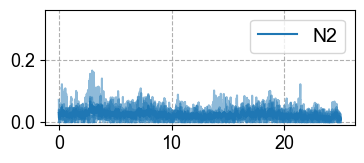

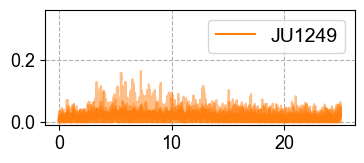

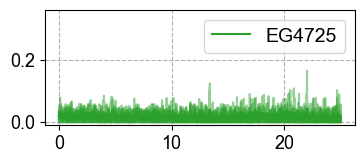

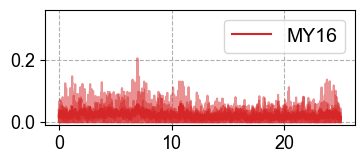

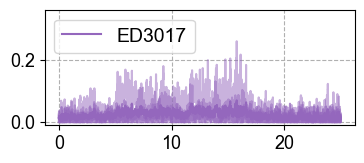

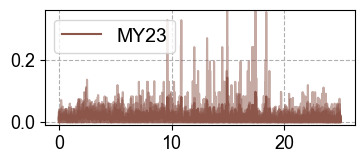

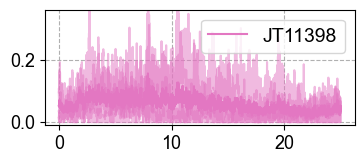

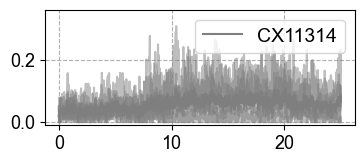

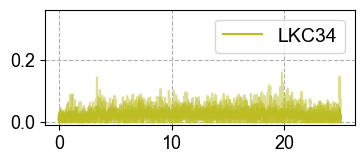

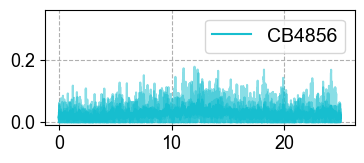

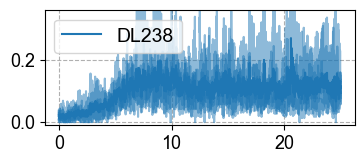

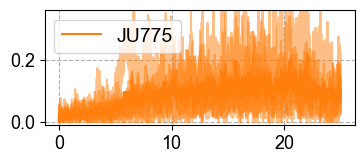

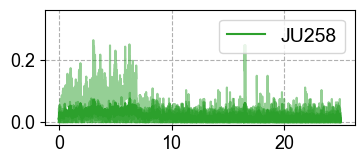

In [8]:
for ks in range(len(strains)):
    fig = plt.figure(figsize=(4, 1.5))
    plt.plot(np.linspace(0,25,daggs_tavg_strain[ks].shape[1]),np.mean(daggs_tavg_strain[ks],axis=0),c='C{}'.format(ks),label=strains[ks])
    for kexp in range(daggs_tavg_strain[ks].shape[0]):   #len(acfs_strains[ks])
        plt.plot(np.linspace(0,25,daggs_tavg_strain[ks].shape[1]),daggs_tavg_strain[ks][kexp],c='C{}'.format(ks),alpha=.5)
    plt.grid(ls='--')
    plt.ylim(-0.01,0.36)
    plt.legend()
    plt.show()

Text(0.55, 0.01, 't (min)')

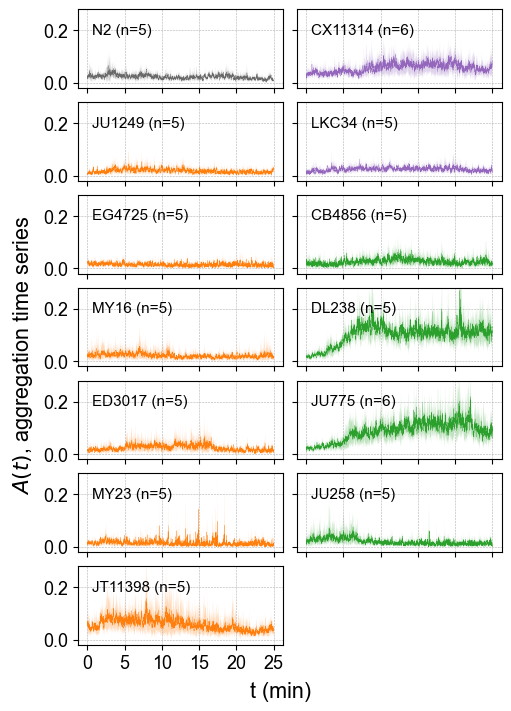

In [9]:
fig,axs = plt.subplots(7,2, figsize=(5,7), sharex=True, sharey=True, constrained_layout=True)
C=['dimgrey','C1','C1','C1','C1','C1','C1','C4','C4','C2','C2','C2','C2'] #C0
for ks in range(len(strains)):
    mean,cil,ciu = bootstrap(daggs_tavg_strain[ks],n_times=100)
    axs[ks%7, int(ks/7)].plot(np.linspace(0,25,daggs_tavg_strain[ks].shape[1]), mean,c=C[ks],label=strains[ks]+' (n={})'.format(daggs_tavg_strain[ks].shape[0]), linewidth=0.2)
    axs[ks%7, int(ks/7)].fill_between(np.linspace(0,25,daggs_tavg_strain[ks].shape[1]) ,cil,ciu,alpha=.3, facecolor=C[ks])    
    axs[ks%7, int(ks/7)].grid(ls='--', linewidth=0.4)
    axs[ks%7, int(ks/7)].set_ylim(-0.02,0.28)
    axs[ks%7, int(ks/7)].set_xticks(np.linspace(0,25,6))
    axs[ks%7, int(ks/7)].legend(loc='upper left',fontsize=11,handlelength=0, handletextpad=0,frameon=False)
    #plt.show()
axs[6,1].set_axis_off()
fig.supylabel('$A(t)$, aggregation time series')
fig.supxlabel('t (min)', x=0.55)
#fig.savefig('/Users/ykang/Desktop/13strains_agg.pdf', bbox_inches='tight')

## compare aggregation metrics

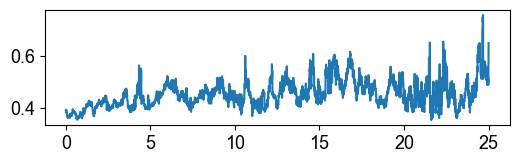

Text(0.5, 0, 't (min)')

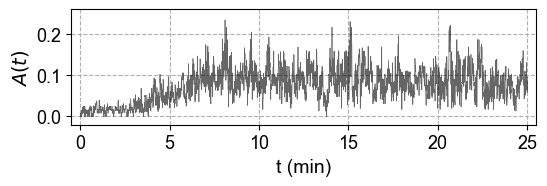

In [15]:
f = h5py.File('/Users/ykang/YJ_writing/Evo_Agg_paper/dataset/pharinx_centroids_strain.h5','r')
X_pos = ma.masked_invalid(np.array(f[str(D)]['DL238']['X_pos'])[:,:,::sampling_time])
X_pos[X_pos==0] = ma.masked
kexp=1
sel = ~np.array([np.all(X_pos[kexp][kw].mask) for kw in range(X_pos[kexp].shape[0])],dtype=bool)
worm_indices = np.arange(X_pos.shape[1])[sel]
X_w = ma.filled(X_pos[kexp][sel],np.nan)

fig = plt.figure(figsize=(6, 1.5))
std_agg = 1/np.linalg.norm( ma.masked_invalid(X_w).std(axis=0), axis=1)
plt.plot(np.linspace(0,25,len(std_agg)), std_agg)#/np.vstack(unif_std_agg).mean(axis=0))
plt.show()
######################################################
ks=10 #DL238
rep=1
fig = plt.figure(figsize=(6, 1.5))
plt.plot(np.linspace(0,25,aggs_strain[ks].shape[1]),daggs_tavg_strain[ks][rep,:],
         c='k', alpha=0.6, label='(n=5)', linewidth=0.5)  #daggs_tavg_strain  #aggs_strain
plt.grid(ls='--')
plt.xlim(-0.5,25.5)
plt.ylim(-0.02,0.26)
plt.ylabel('$A(t)$')
plt.xlabel('t (min)')
#plt.savefig('/Users/ykang/Desktop/DL238_A_rep1_.pdf', bbox_inches='tight')

  0%|          | 0/100 [00:00<?, ?it/s]

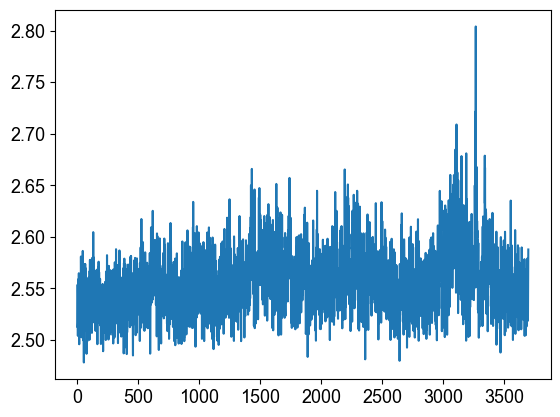

In [11]:
#uniform std_agg estimation
np.random.seed(167)
unif_std_agg=[]
for boot in tqdm( range(100) ):
    boot_unif_std_agg=[]
    for n in nworms_strain[ks][rep,:].astype(int):
        temp_coord = np.random.rand(n,2)
        temp_std_agg = 1/np.linalg.norm( temp_coord.std(axis=0) )
        boot_unif_std_agg.append(temp_std_agg)
    unif_std_agg.append(boot_unif_std_agg)
np.vstack(unif_std_agg).shape
plt.plot(np.vstack(unif_std_agg).mean(axis=0) )

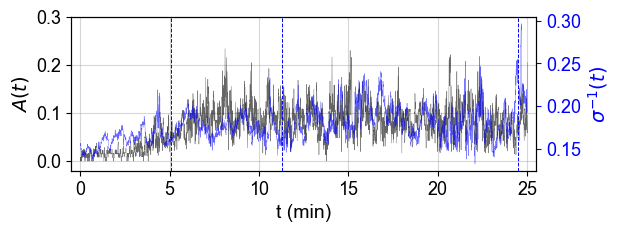

In [16]:
fig, ax1 = plt.subplots(figsize=(6, 2))
plt.grid(ls='-', alpha=0.5)
ax2 = ax1.twinx()
ax1.plot(np.linspace(0,25,aggs_strain[ks].shape[1]),daggs_tavg_strain[ks][rep,:], c='k', alpha=0.6, label='1/h', linewidth=0.3)
ax2.plot(np.linspace(0,25,len(std_agg)), std_agg/np.vstack(unif_std_agg).mean(axis=0), c='blue', alpha=0.6, label='1/$\sigma$', linewidth=0.3)
ax1.set_xlabel('t (min)')
ax1.set_xlim(-0.5,25.5)
ax1.set_ylim(-0.02,0.3)
ax1.set_ylabel('$A(t)$', color='k')
#ax2.set_ylim(-0.02,0.3)
ax2.set_ylabel('$\sigma^{-1}(t)$', color='blue')
ax2.tick_params(axis='y', colors='blue')
ax2.axvline( np.linspace(0,25,aggs_strain[ks].shape[1])[3621], c='blue', ls='--', linewidth=0.7)
ax2.axvline( np.linspace(0,25,aggs_strain[ks].shape[1])[1666], c='blue', ls='--', linewidth=0.7)
ax2.axvline( np.linspace(0,25,aggs_strain[ks].shape[1])[750], c='blue', ls='--', linewidth=0.7)
#fig.legend(loc='upper left')
#fig.savefig('/Users/ykang/Desktop/agg_metrics.pdf', bbox_inches='tight')
plt.show()

Text(0.55, 0.01, 't (min)')

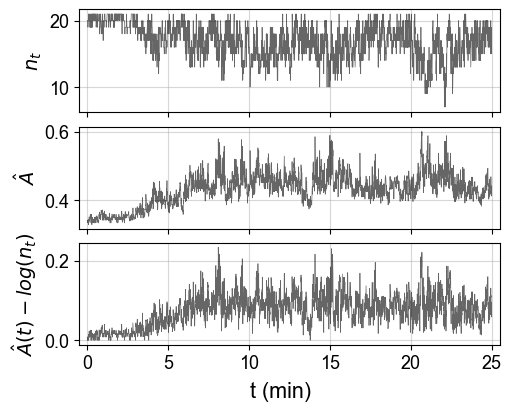

In [17]:
ks=10 #DL238
rep=1

fig,axs = plt.subplots(3,1, figsize=(5,4), sharex=True, sharey=False, constrained_layout=True)
axs[0].plot(np.linspace(0,25,nworms_strain[ks].shape[1]),nworms_strain[ks][rep,:],
         c='k', alpha=0.6, label='(n=5)', linewidth=0.5)
axs[1].plot(np.linspace(0,25,aggs_strain[ks].shape[1]),aggs_strain[ks][rep,:],
         c='k', alpha=0.6, label='(n=5)', linewidth=0.5)
axs[2].plot(np.linspace(0,25,daggs_tavg_strain[ks].shape[1]),daggs_tavg_strain[ks][rep,:],
         c='k', alpha=0.6, label='(n=5)', linewidth=0.5)
axs[0].set_xlim(-0.5,25.5)
axs[0].set_ylabel('$n_{t}$')
axs[0].grid(ls='-', alpha=0.5)
axs[1].set_ylabel('$\hat{A}$')
axs[1].grid(ls='-', alpha=0.5)
axs[2].set_ylabel('$\hat{A}(t) - log(n_{t})$')
axs[2].grid(ls='-', alpha=0.5)
fig.supxlabel('t (min)', x=0.55)
#fig.savefig('/Users/ykang/Desktop/DL238_agg_normalise.pdf', bbox_inches='tight')

## Compute autocorrelation

In [18]:
lags = np.arange(0,int(8*60/(wsize*dt)),int(10/(wsize*dt)))  #time interval as single averaged window, longest lag as 8 min. 

acfs_strains = []
for ks in range(len(strains)):
    acfs_exp = np.zeros((len(daggs_tavg_strain[ks]),len(lags)))
    for kexp in range(len(daggs_strain[ks])):
        acfs_exp[kexp] = acf(daggs_tavg_strain[ks][kexp],lags)
    acfs_strains.append(acfs_exp)

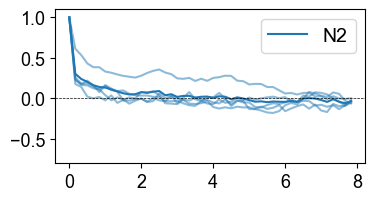

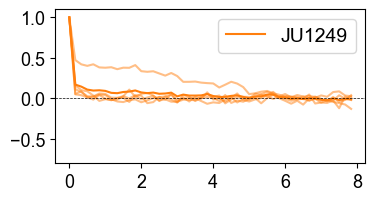

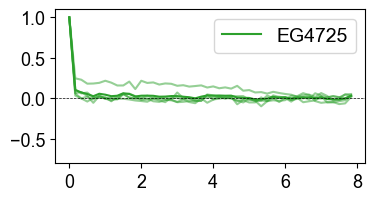

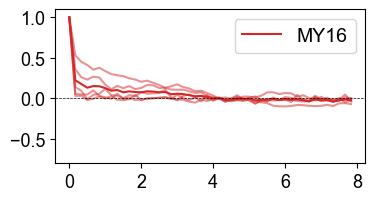

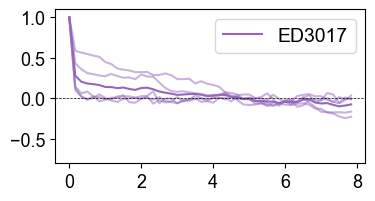

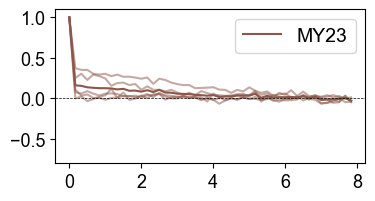

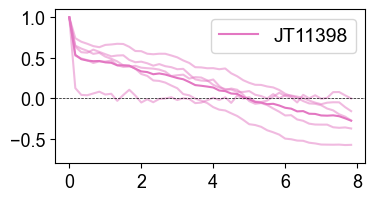

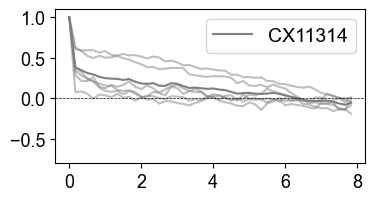

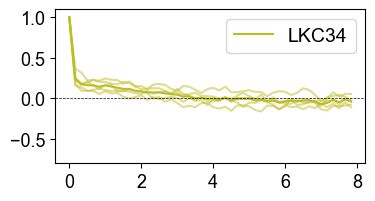

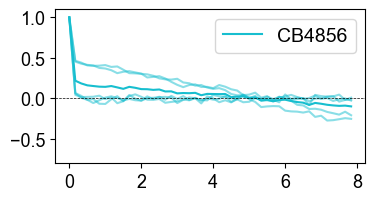

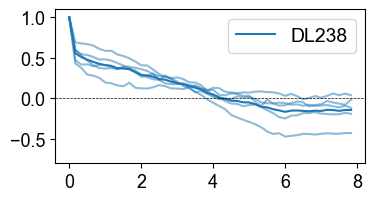

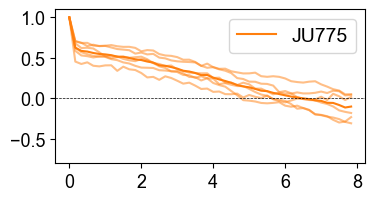

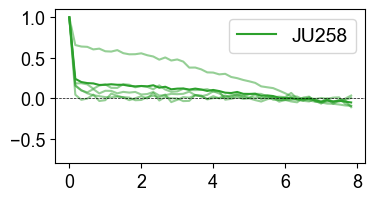

In [19]:
for ks in range(len(strains)):
    fig = plt.figure(figsize=(4, 2))
    plt.plot(lags*dt*wsize/60,np.mean(acfs_strains[ks],axis=0),c='C{}'.format(ks),label=strains[ks])
    for kexp in range(len(acfs_strains[ks])):
        plt.plot(lags*dt*wsize/60,acfs_strains[ks][kexp],c='C{}'.format(ks),alpha=.5)
    plt.axhline(0,c='k', ls='--', linewidth=0.5)
    plt.ylim(-0.8, 1.1)
    plt.legend()
    plt.show()

Text(0.55, 0.01, '$\\tau$ (min)')

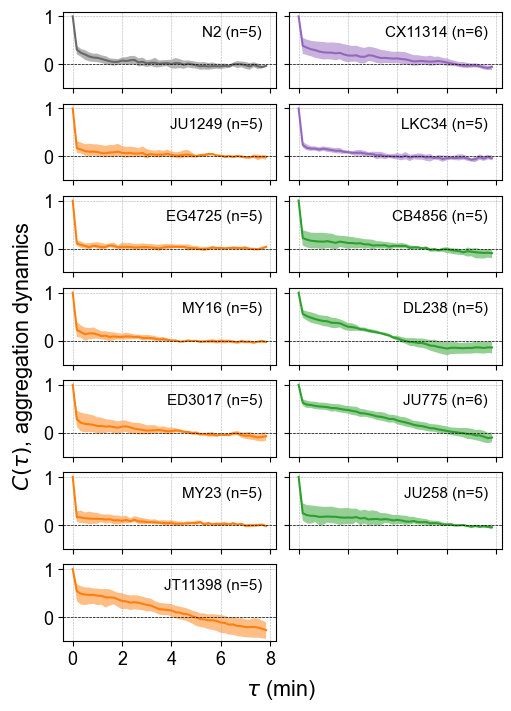

In [20]:
fig,axs = plt.subplots(7,2, figsize=(5,7), sharex=True, sharey=True, constrained_layout=True)
C=['dimgrey','C1','C1','C1','C1','C1','C1','C4','C4','C2','C2','C2','C2']
for ks in range(len(strains)):
    mean,cil,ciu = bootstrap(acfs_strains[ks],n_times=100)
    axs[ks%7, int(ks/7)].plot(lags*wsize*dt/60,mean,c=C[ks],label=strains[ks]+' (n={})'.format(daggs_tavg_strain[ks].shape[0]))
    axs[ks%7, int(ks/7)].fill_between(lags*wsize*dt/60,cil,ciu,alpha=.5,facecolor=C[ks])
    axs[ks%7, int(ks/7)].axhline(0,c='k', linewidth=0.5, ls='--')
    axs[ks%7, int(ks/7)].grid(ls='--', linewidth=0.4)
    axs[ks%7, int(ks/7)].set_ylim(-0.5, 1.1)
    axs[ks%7, int(ks/7)].set_xticks(np.linspace(0,8,5))
    axs[ks%7, int(ks/7)].legend(loc='upper right',fontsize=11,handlelength=0, handletextpad=0,frameon=False)
axs[6,1].set_axis_off()
fig.supylabel(r'$C(\tau)$, aggregation dynamics')
fig.supxlabel(r"$\tau$ (min)", x=0.55)
#fig.savefig('/Users/ykang/Desktop/13strains_dyn.pdf', bbox_inches='tight')

## Mean aggregation magnitude & persistence

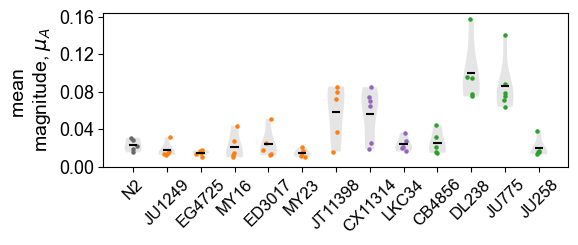

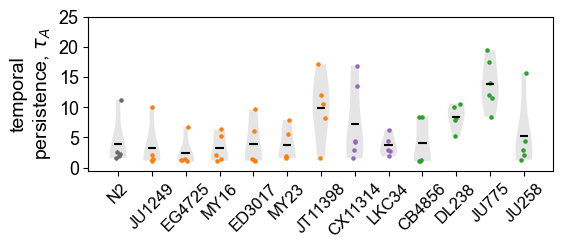

In [21]:
plt.figure(figsize=(6,2))
violin_list=[]
for ks in range(len(strains)):
    violin_list.append(list(daggs_strain[ks].mean(axis=1)))
parts=plt.violinplot(violin_list, positions=np.arange(len(strains)), showmeans=True, showmedians=False, showextrema=False)
for pc in parts['bodies']:
    pc.set_facecolor('grey')
    pc.set_alpha(0.2)
for ks in range(len(strains)):
    plt.scatter(np.random.normal(ks,.05,len(acfs_strains[ks])),daggs_strain[ks].mean(axis=1), s=5, c=C[ks])
parts['cmeans'].set_color('black')
plt.xticks(np.arange(len(strains)),strains,rotation=45, ha='center', fontsize=12)
plt.yticks(np.linspace(0,0.16,5))
plt.ylabel('mean \nmagnitude, $\mu_{A}$')
#plt.savefig('/Users/ykang/Desktop/13strains_violin_agg.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(6,2))
violin_list=[]
for ks in range(len(strains)):
    violin_list.append([np.cumsum(acfs_strains[ks][kexp]).max() for kexp in range(len(acfs_strains[ks]))] )  #np.cumsum(acfs_strains[ks][kexp]*np.diff(lags)[0]*(wsize*dt)).max()
parts=plt.violinplot(violin_list, positions=np.arange(len(strains)), showmeans=True, showmedians=False, showextrema=False)
for pc in parts['bodies']:
    pc.set_facecolor('grey')
    pc.set_alpha(0.2)
for ks in range(len(strains)):
    plt.scatter(np.random.normal(ks,.05,len(acfs_strains[ks])),[np.cumsum(acfs_strains[ks][kexp]).max() for kexp in range(len(acfs_strains[ks]))], s=5, c=C[ks])
parts['cmeans'].set_color('black')
plt.xticks(np.arange(len(strains)),strains,rotation=45, ha='center', fontsize=12)
plt.ylim(-0.5,25)
plt.yticks(np.linspace(0,25,6))
plt.ylabel('temporal\npersistence, $\\tau_{A}$')
#plt.savefig('/Users/ykang/Desktop/13strains_violin_dyn.pdf', bbox_inches='tight')
plt.show()

plotted by different climate groups.

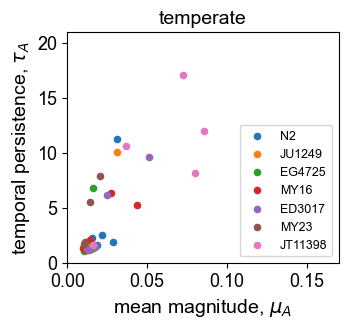

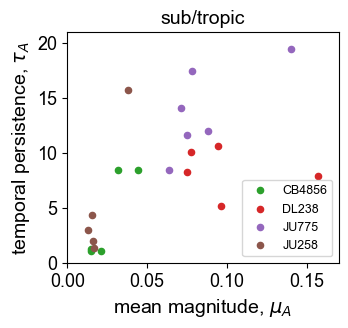

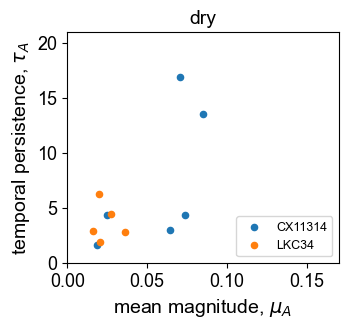

In [24]:
cmap=plt.get_cmap('tab10') 
plt.figure(figsize=(3.5,3))
x = np.hstack([daggs_tavg_strain[ks].mean(axis=1) for ks in range(len(strains))])
y = np.hstack([[np.cumsum(acfs_strains[ks][kexp]).max() for kexp in range(len(acfs_strains[ks]))] for ks in range(len(strains))])
for ks in range(0,7):
    plt.scatter(x[strain_labels==ks],y[strain_labels==ks],label=strains[ks], s=20, color=cmap(ks))
    #plt.text(x[strain_labels==ks][0],y[strain_labels==ks].data[0], strains[ks], fontsize=8)
plt.legend(loc='lower right', fontsize=9)
plt.xlabel('mean magnitude, $\\mu_{A}$')
plt.ylabel('temporal persistence, $\\tau_{A}$')
plt.xlim(0,0.17)
plt.ylim(0,21)
plt.title('temperate')
#plt.savefig('/Users/ykang/Desktop/temperate_agg_dyn.pdf', bbox_inches='tight')
plt.show()

cmap=plt.get_cmap('tab10')
plt.figure(figsize=(3.5,3))
x = np.hstack([daggs_tavg_strain[ks].mean(axis=1) for ks in range(len(strains)) ])
y = np.hstack([[np.cumsum(acfs_strains[ks][kexp]).max() for kexp in range(len(acfs_strains[ks]))] for ks in range(len(strains))])
for ks in range(9,len(strains)):
    plt.scatter(x[strain_labels==ks],y[strain_labels==ks],label=strains[ks], s=20, color=cmap(ks-7))
    #plt.text(x[strain_labels==ks][0],y[strain_labels==ks].data[0], strains[ks], fontsize=8)
plt.legend(loc='lower right', fontsize=9)
plt.xlabel('mean magnitude, $\\mu_{A}$')
plt.ylabel('temporal persistence, $\\tau_{A}$')
plt.xlim(0,0.17)
plt.ylim(0,21)
plt.title('sub/tropic')
#plt.savefig('/Users/ykang/Desktop/tropics_agg_dyn.pdf', bbox_inches='tight')
plt.show()

cmap=plt.get_cmap('tab10')
plt.figure(figsize=(3.5,3))
x = np.hstack([daggs_tavg_strain[ks].mean(axis=1) for ks in range(len(strains)) ])
y = np.hstack([[np.cumsum(acfs_strains[ks][kexp]).max() for kexp in range(len(acfs_strains[ks]))] for ks in range(len(strains))])
for ks in range(7,9):
    plt.scatter(x[strain_labels==ks],y[strain_labels==ks],label=strains[ks], s=20, color=cmap(ks-7))
    #plt.text(x[strain_labels==ks][0],y[strain_labels==ks].data[0], strains[ks], fontsize=8)
plt.legend(loc='lower right', fontsize=9)
plt.xlabel('mean magnitude, $\\mu_{A}$')
plt.ylabel('temporal persistence, $\\tau_{A}$')
plt.xlim(0,0.17)
plt.ylim(0,21)
plt.title('dry')
#plt.savefig('/Users/ykang/Desktop/others_agg_dyn.pdf', bbox_inches='tight')
plt.show()

___
## Genetic relations among strains

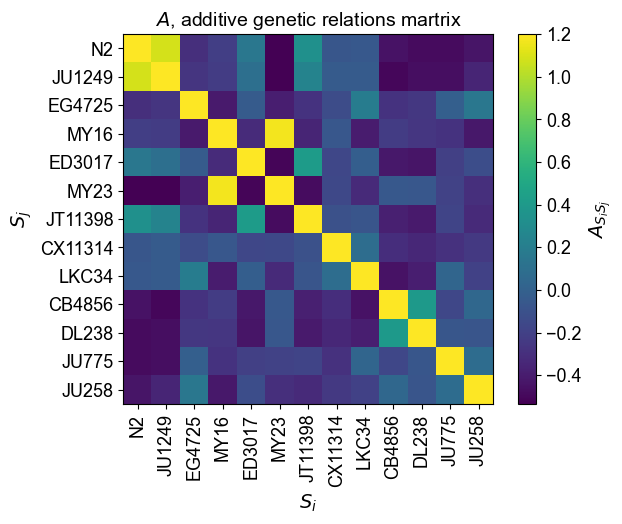

In [25]:
geno_mat = np.genfromtxt("/Users/ykang/YJ_writing/Evo_Agg_paper/dataset/Geno_mat.csv", delimiter=" ")
plt.imshow(geno_mat, vmax=1.2)
plt.colorbar(label='$A_{S_{i}S_{j}}$')
plt.title("$A$, additive genetic relations martrix")
plt.xticks(np.arange(len(strains)),strains,rotation=90, ha='center')
plt.yticks(np.arange(len(strains)),strains,rotation=0, ha='right')
plt.xlabel('$S_{i}$')
plt.ylabel('$S_{j}$')
plt.savefig('/Users/ykang/Desktop/A_mat.pdf', bbox_inches='tight')
plt.show()

___
## Environmental covariance

### Geographic coordinates

In [26]:
# load geographic coordinates.
geo_df=pd.read_csv("/Users/ykang/YJ_writing/Evo_Agg_paper/dataset/20231213_c_elegans_strain_data.csv")

In [27]:
# 13 divergent strains index
strain_idx=[]
for i in range(len(strains)):
    strain_idx += geo_df[geo_df['strain']==strains[i]].index.to_list()
strain_idx

[1218, 769, 739, 1103, 713, 1140, 748, 18, 90, 2, 26, 1083, 850]

In [28]:
fin_geo_df=geo_df.loc[strain_idx][["strain","latitude","longitude"]]

new_lon=[]
for i in range(len(strains)):
    if np.array(fin_geo_df['longitude'])[i]<0: 
        new_lon.append( np.array(fin_geo_df['longitude'])[i]+360 )
    else:
        new_lon.append( np.array(fin_geo_df['longitude'])[i] )

fin_geo_df['longitude']=new_lon
fin_geo_df

,strain,latitude,longitude
1218,N2,51.450000,357.410000
769,JU1249,49.126000,1.951000
739,EG4725,41.628800,351.652400
1103,MY16,51.930000,7.570000
713,ED3017,55.920000,356.810000
1140,MY23,51.960000,7.530000
748,JT11398,47.763944,237.724516
18,CX11314,34.129460,241.890130
90,LKC34,-18.000000,46.000000
2,CB4856,21.330000,202.140000


### Climate data

In [29]:
import netCDF4
fp='/Users/ykang/YJ_writing/Evo_Agg_paper/dataset/AerChem/temp/tas_Amon_CNRM-ESM2-1_historical_r1i1p1f2_gr_20000116-20141216.nc'
fp_moist='/Users/ykang/YJ_writing/Evo_Agg_paper/dataset/AerChem/moist/mrsos_Lmon_CNRM-ESM2-1_historical_r1i1p1f2_gr_20000116-20141216.nc'
fp_humid='/Users/ykang/YJ_writing/Evo_Agg_paper/dataset/AerChem/humid/hurs_Amon_CNRM-ESM2-1_historical_r1i1p1f2_gr_20000116-20141216.nc'

nc = netCDF4.Dataset(fp)
nc_moist = netCDF4.Dataset(fp_moist)
nc_humid= netCDF4.Dataset(fp_humid)

nc.variables
nc_moist.variables
#nc_humid.variables

#nc['time'][:]  #every month, from year 2000~2014.
#nc['lat'][:]  #-90~90 degrees.
#nc['lon'][:]  #0~360 degrees.
#nc['tas'][:]   #near-surface temperature in Kelvin.
#nc_moist['mrsos'][:]  #moisture in upper column soil. kg m-2
#nc_humid['hurs'][:]  #near surface relative humidity in %

{'lat': <class 'netCDF4._netCDF4.Variable'>
 float64 lat(lat)
     axis: Y
     standard_name: latitude
     long_name: Latitude
     units: degrees_north
 unlimited dimensions: 
 current shape = (128,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'lon': <class 'netCDF4._netCDF4.Variable'>
 float64 lon(lon)
     axis: X
     standard_name: longitude
     long_name: Longitude
     units: degrees_east
 unlimited dimensions: 
 current shape = (256,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'depth': <class 'netCDF4._netCDF4.Variable'>
 float64 depth()
     name: depth
     standard_name: depth
     long_name: depth
     units: m
     axis: Z
     positive: down
     bounds: depth_bounds
 unlimited dimensions: 
 current shape = ()
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'depth_bounds': <class 'netCDF4._netCDF4.Variable'>
 float64 depth_bounds(axis_nbounds)
 unlimited dimensions: 
 current shape = (2,)
 filling on, default _Fi

In [30]:
err=0.7
surface_temp_strains=[]
surface_humid_strains=[]
moist_soil_strains=[]
for strain in range(len(strains)):
    #print(strains[strain])
    lat_idx = ma.where( (nc_humid['lat'][:]-fin_geo_df.iloc[strain][1])**2 <= (err)**2 )[0][0]
    lon_idx = ma.where( (nc_humid['lon'][:]-fin_geo_df.iloc[strain][2])**2 <= (err)**2 )[0][0]
    #print(ma.where( (nc_humid['lat'][:]-fin_geo_df.iloc[strain][1])**2 <= (0.7)**2 ))
    surface_temp_strains.append( nc['tas'][:,lat_idx,lon_idx]-273.15 ) # Kelvin to Celsius 
    surface_humid_strains.append( nc_humid['hurs'][:,lat_idx,lon_idx] ) # relative humidity %
    moist_soil_strains.append( nc_moist['mrsos'][:,lat_idx,lon_idx] ) # kg m-2
surface_humid_strains[11].shape  #strain 11

(180,)

Text(0.02, 0.5, 'near surface temperature ($^\\circ$C)')

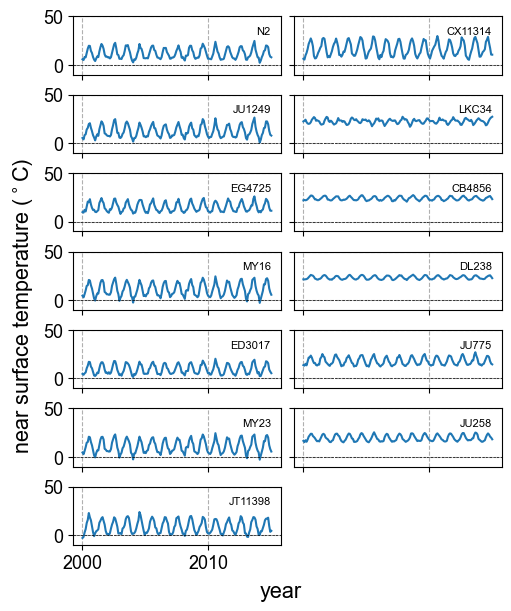

In [31]:
fig,axs = plt.subplots(7,2, figsize=(5,6), sharex=True, sharey=True, constrained_layout=True)
for ks in range(len(strains)):
    axs[ks%7, int(ks/7)].plot(2000+np.linspace(0,15,len(surface_temp_strains[ks])),surface_temp_strains[ks], label=strains[ks])
    axs[ks%7, int(ks/7)].axhline(0,c='k', linewidth=0.5, ls='--')
    axs[ks%7, int(ks/7)].grid(ls='--')
    axs[ks%7, int(ks/7)].set_ylim(-10,50)
    axs[ks%7, int(ks/7)].legend(loc='upper right', fontsize=8,handlelength=0, handletextpad=0,frameon=False)
axs[6,1].set_axis_off()
fig.supxlabel('year', x=0.55)
fig.supylabel('near surface temperature ($^\circ$C)')
#fig.savefig('/Users/ykang/Desktop/temp.pdf', bbox_inches='tight')

Text(0.02, 0.5, 'near surface humidity (%)')

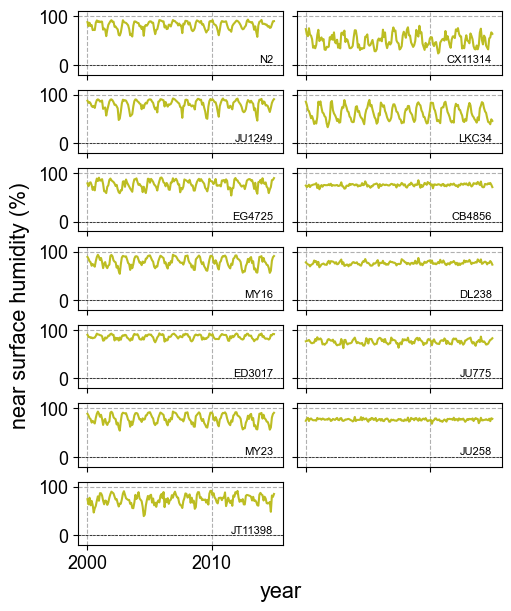

In [32]:
fig,axs = plt.subplots(7,2, figsize=(5,6), sharex=True, sharey=True, constrained_layout=True)
for ks in range(len(strains)):
    axs[ks%7, int(ks/7)].plot(2000+np.linspace(0,15,len(surface_temp_strains[ks])), surface_humid_strains[ks], label=strains[ks], color='C8')
    axs[ks%7, int(ks/7)].axhline(0,c='k', linewidth=0.5, ls='--')
    axs[ks%7, int(ks/7)].grid(ls='--')
    axs[ks%7, int(ks/7)].set_ylim(-20,110)
    axs[ks%7, int(ks/7)].legend(loc='lower right', fontsize=8,handlelength=0, handletextpad=0,frameon=False)
    #axs[ks%7, int(ks/7)].set_xticks(np.linspace(2000))
axs[6,1].set_axis_off()
fig.supxlabel('year', x=0.55)
fig.supylabel('near surface humidity (%)')
#fig.savefig('/Users/ykang/Desktop/humid.pdf', bbox_inches='tight')

Text(0.02, 0.5, 'soil moisture (kg/m$^{2}$)')

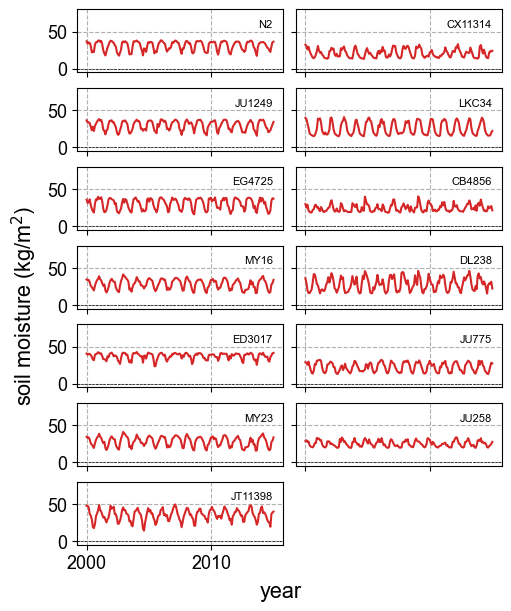

In [33]:
fig,axs = plt.subplots(7,2, figsize=(5,6), sharex=True, sharey=True, constrained_layout=True)
for ks in range(len(strains)):
    axs[ks%7, int(ks/7)].plot(2000+np.linspace(0,15,len(surface_temp_strains[ks])), moist_soil_strains[ks], label=strains[ks], color='C3')
    axs[ks%7, int(ks/7)].axhline(0,c='k', linewidth=0.5, ls='--')
    axs[ks%7, int(ks/7)].grid(ls='--')
    axs[ks%7, int(ks/7)].set_ylim(-5,80)
    axs[ks%7, int(ks/7)].legend(loc='upper right', fontsize=8,handlelength=0, handletextpad=0,frameon=False)
axs[6,1].set_axis_off()
fig.supxlabel('year', x=0.55)
fig.supylabel('soil moisture (kg/m$^{2}$)')
#fig.savefig('/Users/ykang/Desktop/moist.pdf', bbox_inches='tight')

### Correlation between climate data & behaviour

In [34]:
err=0.7
surface_temp_strains=[]
surface_humid_strains=[]
moist_soil_strains=[]
for strain in range(1,len(strains)):   #exclude N2
    #print(strains[strain])
    lat_idx = ma.where( (nc_humid['lat'][:]-fin_geo_df.iloc[strain][1])**2 <= (err)**2 )[0][0]
    lon_idx = ma.where( (nc_humid['lon'][:]-fin_geo_df.iloc[strain][2])**2 <= (err)**2 )[0][0]
    #print(ma.where( (nc_humid['lat'][:]-fin_geo_df.iloc[strain][1])**2 <= (0.7)**2 ))
    surface_temp_strains.append( nc['tas'][:,lat_idx,lon_idx]-273.15 ) # Kelvin to Celsius 
    surface_humid_strains.append( nc_humid['hurs'][:,lat_idx,lon_idx] ) # relative humidity %
    moist_soil_strains.append( nc_moist['mrsos'][:,lat_idx,lon_idx] ) # kg m-2
surface_humid_strains[11].shape  #strain 11

(180,)

In [35]:
#climate vector, unweighted.
temp_strains = np.array(surface_temp_strains).T
humid_strains = np.array(surface_humid_strains).T
moist_strains = np.array(moist_soil_strains).T

env_strains = np.vstack([temp_strains.std(axis=0),temp_strains.mean(axis=0),
                         moist_strains.std(axis=0),moist_strains.mean(axis=0),
                         humid_strains.std(axis=0),humid_strains.mean(axis=0)]).T

#z-scoring both the max norm and the standard deviation
env_strains = (env_strains-env_strains.mean(axis=0))/(env_strains.std(axis=0))

In [36]:
mean_agg = np.hstack([daggs_strain[ks].mean(axis=1) for ks in range(len(strains))])
timescale = np.hstack([[np.cumsum(acfs_strains[ks][kexp]).max() for kexp in range(len(acfs_strains[ks]))] for ks in range(len(strains))])

In [37]:
mean_tau = [timescale[strain_labels==ks].mean() for ks in range(1,len(strains))]
single_mean_agg=[mean_agg[strain_labels==ks].mean() for ks in range(1,len(strains))]

In [38]:
#mean temperature
print( np.corrcoef(env_strains[:,1],mean_tau) )
#mean humidity
print( np.corrcoef(env_strains[:,5],mean_tau) )  #std_mean_agg  #std_tau  #mean_tau  #single_mean_agg
#mean soil moisture
print( np.corrcoef(env_strains[:,3],mean_tau) )

[[1.        0.1128927]
 [0.1128927 1.       ]]
[[ 1.         -0.17369451]
 [-0.17369451  1.        ]]
[[ 1.         -0.23293671]
 [-0.23293671  1.        ]]


In [39]:
#std temperature
print( np.corrcoef(env_strains[:,0],mean_tau) )
#std humidity
print( np.corrcoef(env_strains[:,4],mean_tau) )  #std_mean_agg  #std_tau  #mean_tau  #single_mean_agg
#std moisture
print( np.corrcoef(env_strains[:,2],mean_tau) )

[[ 1.         -0.05642238]
 [-0.05642238  1.        ]]
[[ 1.         -0.22785037]
 [-0.22785037  1.        ]]
[[1.         0.12296734]
 [0.12296734 1.        ]]


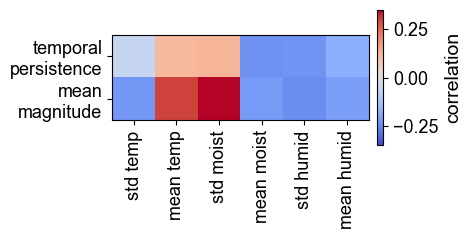

In [40]:
corr_matrix = np.vstack([[np.corrcoef(mean_tau,env_strains[:,kenv])[0,1] for kenv in range(env_strains.shape[1])],
           [[np.corrcoef(single_mean_agg,env_strains[:,kenv])[0,1] for kenv in range(env_strains.shape[1])]]])
plt.figure(figsize=(3.5,3.5))
plt.imshow(corr_matrix,cmap='coolwarm',vmax=.35,vmin=-.35)
plt.colorbar(label='correlation',fraction=0.025, pad=0.03)
plt.xticks(np.arange(6),['std temp','mean temp','std moist','mean moist','std humid','mean humid'], rotation=18090)
plt.yticks(np.arange(2),['temporal\npersistence','mean\nmagnitude'])
#plt.savefig('/Users/ykang/Desktop/env_corr.pdf', bbox_inches='tight')
plt.show()

### Clustering by climate

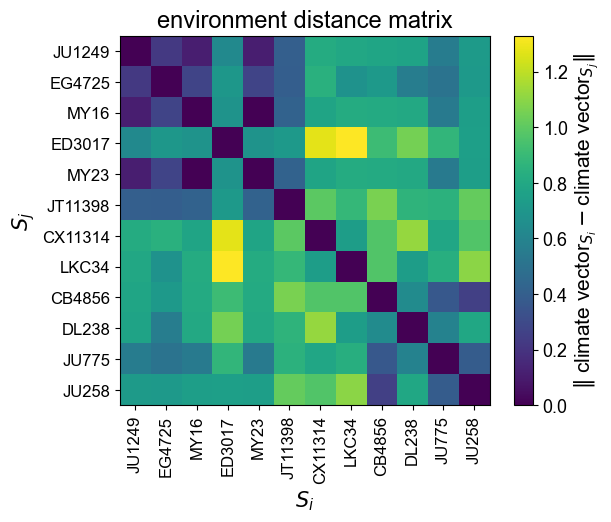

In [42]:
from scipy.spatial.distance import pdist,squareform

#climate vector weighted by correaltion coefficient.
env_strains_weighted = env_strains*np.abs(corr_matrix).mean(axis=0)

env_mat = squareform(pdist(env_strains_weighted))
plt.imshow(env_mat)#, vmax=2)
#plt.title("M$_{env}$")
#plt.colorbar().ax.tick_params(labelsize=15)
plt.colorbar().set_label(label='$\|$ climate vector$_{S_{i}}-$climate vector$_{S_{j}} \|$', size=15)
plt.xticks(np.arange(len(strains)-1),strains[1:],rotation=90, fontsize=12)
plt.yticks(np.arange(len(strains)-1),strains[1:],rotation=0, fontsize=12)
plt.xlabel('$S_{i}$', fontsize=15)
plt.ylabel('$S_{j}$', fontsize=15)
plt.title('environment distance matrix', fontsize=17)
#plt.savefig('/Users/ykang/Desktop/env_mat.pdf', bbox_inches='tight')
plt.show()

In [43]:
def CSE(D):
    """
    Perform constant shift embedding and return eigenvalues and eigenvectors on a distance matrix 
    """
    n = D.shape[0]
    
    Q = np.eye(n) - (1/n)*np.dot(np.ones((n,1)), np.ones((1,n)))
    # print(Q)
    Sc = -0.5*(np.dot(Q,np.dot(D,Q)))
    ei1, _ = np.linalg.eig(Sc)
    Dtilde = D - 2*(np.min(ei1))*(np.dot(np.ones((n,1)), np.ones((1,n))) - np.eye(n))

    Sctilde = -0.5*(np.dot(Q,np.dot(Dtilde,Q)))
    ei_fin, ev = np.linalg.eig(Sctilde)
    sorted_idx = np.argsort(ei_fin)[::-1]
    ei_fin = ei_fin[sorted_idx].real
    ev = ev[:,sorted_idx].real
    
    return ei_fin, ev

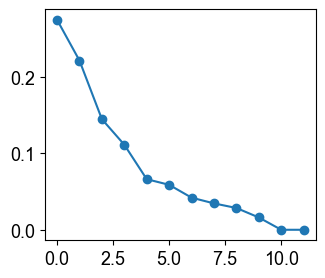

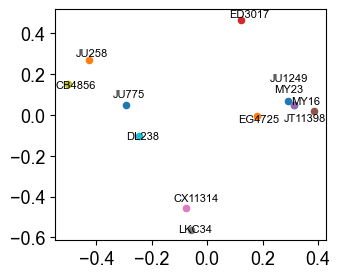

In [45]:
from adjustText import adjust_text

eigvals,eigvecs = CSE(env_mat)

plt.figure(figsize=(3.5,3))
plt.plot(eigvals/eigvals.sum(),marker='o')
plt.show()
Xp = np.dot(eigvecs[:,:3], np.sqrt(np.diag(eigvals[:3])))

plt.figure(figsize=(3.5,3))
#plt.xlim(-0.42,0.42)
#plt.ylim(-0.5,0.3)
texts=[]
for ks,strain in enumerate(strains[1:]):
    plt.scatter(Xp[ks,0],Xp[ks,1],label=strain, s=20)
    #plt.text(Xp[ks,0]-0.05,Xp[ks,1]+0.01, strain, fontsize=8)
    texts.append(plt.text(Xp[ks,0]-0.05,Xp[ks,1]+0.01, strain, fontsize=8))
adjust_text(texts, only_move={'points':'y', 'texts':'x'})#, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
#plt.savefig('/Users/ykang/Desktop/13strains_dynamics.pdf', bbox_inches='tight')
plt.show()

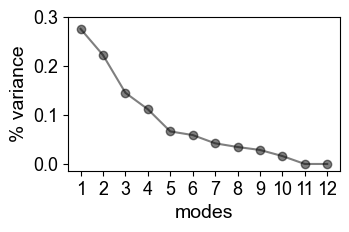

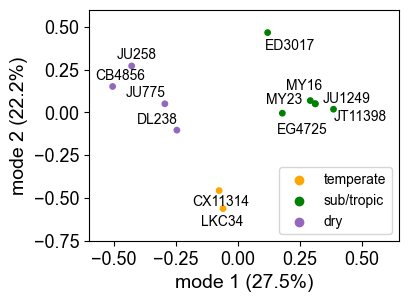

In [47]:
plt.figure(figsize=(3.5,2))
plt.plot(np.arange(len(eigvals)),eigvals/eigvals.sum(),marker='o', color='k', alpha=0.5)
plt.xticks( np.arange(len(eigvals)), labels=np.arange(len(eigvals))+1 )
plt.yticks( np.arange(0,0.35,0.1) )
plt.xlabel('modes')
plt.ylabel('% variance')
#plt.savefig('/Users/ykang/Desktop/cliamte_grouping_percentage.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(4,3))
plt.scatter(np.nan,np.nan, c='orange', label='temperate')
plt.scatter(np.nan,np.nan, c='green', label='sub/tropic')
plt.scatter(np.nan,np.nan, c='C4', label='dry')
plt.legend(fontsize=10, loc='lower right')

cse_dim=10
Xp = np.dot(eigvecs[:,:cse_dim], np.sqrt(np.diag(eigvals[:cse_dim])))
kmeans = KMeans(n_clusters=3, n_init=10).fit(Xp)
cluster_labels = kmeans.labels_
centers = kmeans.cluster_centers_
plt.scatter(Xp[:,0],Xp[:,1],c=np.array(['orange','green','C4'])[cluster_labels], s=15)

plt.text(Xp[0,0]+0.05,Xp[0,1]-0.01, strains[1:][0], fontsize=10)
plt.text(Xp[1,0]-0.02,Xp[1,1]-0.12, strains[1:][1], fontsize=10)
plt.text(Xp[2,0]-0.12,Xp[2,1]+0.08, strains[1:][2], fontsize=10) #my16
plt.text(Xp[3,0]-0.01,Xp[3,1]-0.1, strains[1:][3], fontsize=10)#ed3017
plt.text(Xp[4,0]-0.2,Xp[4,1]+0.0, strains[1:][4], fontsize=10) #my23
plt.text(Xp[5,0],Xp[5,1]-0.07, strains[1:][5], fontsize=10)#

plt.text(Xp[6,0]-0.11,Xp[6,1]-0.09, strains[1:][6], fontsize=10)
plt.text(Xp[7,0]-0.09,Xp[7,1]-0.1, strains[1:][7], fontsize=10)

plt.text(Xp[8,0]-0.07,Xp[8,1]+0.04, strains[1:][8], fontsize=10)
plt.text(Xp[9,0]-0.16,Xp[9,1]+0.04, strains[1:][9], fontsize=10)
plt.text(Xp[10,0]-0.16,Xp[10,1]+0.04, strains[1:][10], fontsize=10)
plt.text(Xp[11,0]-0.06,Xp[11,1]+0.04, strains[1:][11], fontsize=10)

plt.xlim(-0.6,0.65)
plt.ylim(-0.75,0.6)
plt.xlabel('mode 1 (27.5%)')
plt.ylabel('mode 2 (22.2%)')
#plt.savefig('/Users/ykang/Desktop/cliamte_grouping.pdf', bbox_inches='tight')
plt.show()

### Assess cluster stability

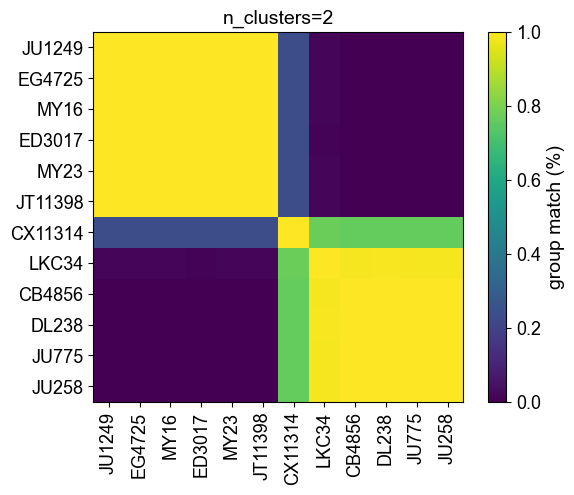

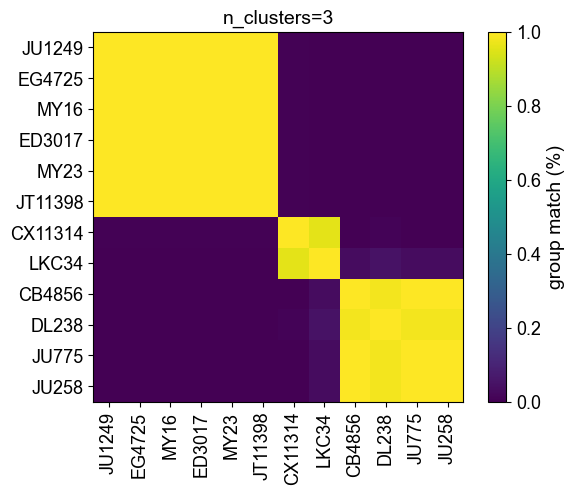

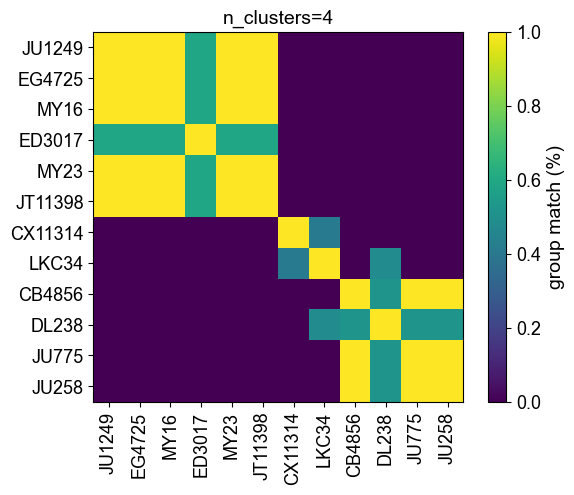

In [49]:
from itertools import combinations

n_samples=1000
cse_dim=10
stability=[]
np.random.seed(105)
for n_clusters in range(2,5):  #2,5
    labels_sample = []
    for k in range(n_samples):
        temp_mean_sample = temp_strains[np.random.randint(0,temp_strains.shape[0],temp_strains.shape[0])].mean(axis=0)
        temp_std_sample = temp_strains[np.random.randint(0,temp_strains.shape[0],temp_strains.shape[0])].std(axis=0)

        humid_mean_sample = humid_strains[np.random.randint(0,humid_strains.shape[0],humid_strains.shape[0])].mean(axis=0)
        humid_std_sample = humid_strains[np.random.randint(0,humid_strains.shape[0],humid_strains.shape[0])].std(axis=0)

        moist_mean_sample = moist_strains[np.random.randint(0,moist_strains.shape[0],moist_strains.shape[0])].mean(axis=0)
        moist_std_sample = moist_strains[np.random.randint(0,moist_strains.shape[0],moist_strains.shape[0])].std(axis=0)

        X_sample = np.vstack([temp_std_sample,temp_mean_sample,moist_std_sample,moist_mean_sample,humid_std_sample,humid_mean_sample]).T
        Zsample = (X_sample-X_sample.mean(axis=0))/(X_sample.std(axis=0)) #z-scoring both the max norm and the standard deviation
        D = squareform(pdist(Zsample))
        eigvals,eigvecs = CSE(D)
        Xp = np.dot(eigvecs[:,:cse_dim], np.sqrt(np.diag(eigvals[:cse_dim])))
        kmeans = KMeans(n_clusters=n_clusters, n_init=10).fit(Xp)
        cluster_labels = kmeans.labels_
        centers = kmeans.cluster_centers_
        labels_sample.append(cluster_labels)
        
    cluster_assignments = np.vstack(labels_sample)
    c =np.zeros((cluster_assignments.shape[1],cluster_assignments.shape[1]))
    for i, j in combinations(range(cluster_assignments.shape[1]), 2):
        c[i,j] = np.sum(cluster_assignments[:, i] == cluster_assignments[:, j])
        c[i,i] = np.sum(cluster_assignments[:, i] == cluster_assignments[:, i])
        c[j,j] = np.sum(cluster_assignments[:, j] == cluster_assignments[:, j])
        c[j,i] = c[i,j]
    plt.title('n_clusters={}'.format(n_clusters))
    plt.imshow(c/n_samples)
    plt.xticks(np.arange(len(strains)-1),strains[1:],rotation=90)
    plt.yticks(np.arange(len(strains)-1),strains[1:],rotation=0)
    plt.colorbar(label='group match (%)')
    #plt.savefig('/Users/ykang/Desktop/cliamte_grouping_bootstrap'+'_{}'.format(n_clusters)+'.pdf', bbox_inches='tight')
    plt.show()
    
    cluster_stab=[]
    for i in c.flatten():   
        if (n_samples-i)>(n_samples/2): cluster_stab.append(n_samples-i)
        else: cluster_stab.append(i)
    stability.append(np.array(cluster_stab)/n_samples)

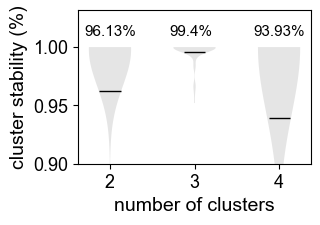

In [52]:
plt.figure(figsize=(3,2))
violin_list=[]
for n_clusters in range(3):
    violin_list.append(list(stability[n_clusters]))
parts=plt.violinplot(violin_list, positions=np.arange(3), showmeans=True, showmedians=False, showextrema=False)
for pc in parts['bodies']:
    pc.set_facecolor('grey')
    pc.set_alpha(0.2)
parts['cmeans'].set_color('black')
parts['cmeans'].set_linewidth(1)
plt.xticks(np.arange(3),np.arange(2,5))
plt.xlabel('number of clusters')
plt.ylabel('cluster stability (%)')
plt.text(0-0.3, 0.95+0.06, '96.13%', fontsize=11)
plt.text(1-0.3, 0.95+0.06, '99.4%', fontsize=11)
plt.text(2-0.3, 0.95+0.06, '93.93%', fontsize=11)
plt.ylim(0.90,1.032)
#plt.savefig('/Users/ykang/Desktop/cluster_stab.pdf', bbox_inches='tight')
plt.show()

### Environment summary

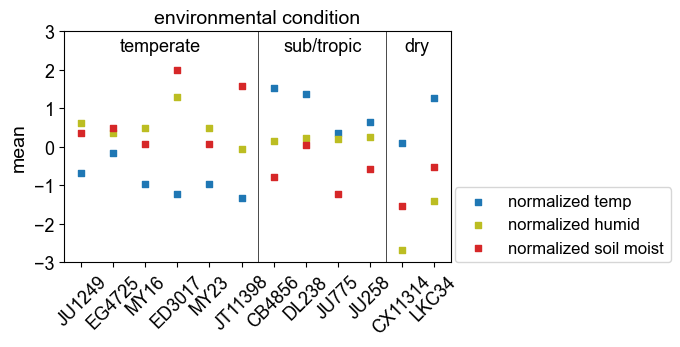

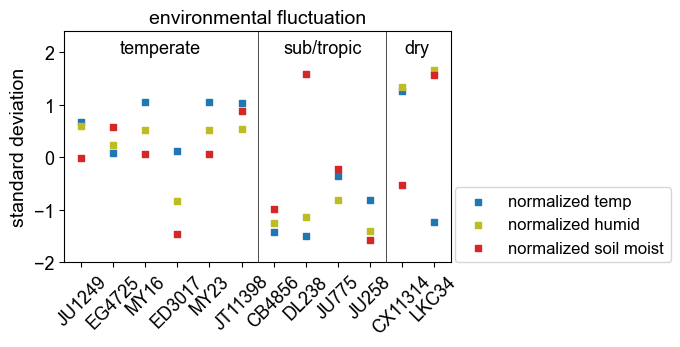

In [53]:
env_strains_list=["JU1249","EG4725","MY16","ED3017","MY23","JT11398", "CB4856","DL238","JU775","JU258", "CX11314","LKC34"]
env_label_index=[]
for i,strain in enumerate(env_strains_list):
    env_label_index.append(strains.index(strain)-1)

plt.figure(figsize=(5,3))
plt.title('environmental condition')
plt.scatter(np.arange(len(strains)-1),env_strains[env_label_index,1], label='normalized temp', marker='s', s=20, color='C0')
plt.scatter(np.arange(len(strains)-1),env_strains[env_label_index,5], label='normalized humid', marker='s', s=20, color='C8')
plt.scatter(np.arange(len(strains)-1),env_strains[env_label_index,3], label='normalized soil moist', marker='s', s=20, color='C3')
plt.axvline(x=5.5, color='k', linewidth=0.5)
plt.axvline(x=9.5, color='k', linewidth=0.5)
plt.legend(loc=(1.01,0.0), fontsize=12)
plt.ylabel('mean')
plt.xticks(np.arange(len(strains)-1),env_strains_list,rotation=45, ha='center')
plt.ylim(-3,3)
plt.text(x=1.2, y=2.5, s='temperate')
plt.text(x=6.3, y=2.5, s='sub/tropic')
plt.text(x=10.1, y=2.5, s='dry')
#plt.savefig('/Users/ykang/Desktop/env_condition.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(5,3))
plt.title('environmental fluctuation')
plt.scatter(np.arange(len(strains)-1),env_strains[env_label_index,0], label='normalized temp', marker='s', s=20, color='C0')
plt.scatter(np.arange(len(strains)-1),env_strains[env_label_index,4], label='normalized humid', marker='s', s=20, color='C8')
plt.scatter(np.arange(len(strains)-1),env_strains[env_label_index,2], label='normalized soil moist', marker='s', s=20, color='C3')
plt.axvline(x=5.5, color='k', linewidth=0.5)
plt.axvline(x=9.5, color='k', linewidth=0.5)
plt.legend(loc=(1.01,0.0), fontsize=12)
plt.ylabel('standard deviation')
plt.xticks(np.arange(len(strains)-1),env_strains_list,rotation=45, ha='center')
plt.ylim(-2,2.4)
plt.text(x=1.2, y=1.98, s='temperate')
plt.text(x=6.3, y=1.98, s='sub/tropic')
plt.text(x=10.1, y=1.98, s='dry')  #'semi\n arid'
#plt.savefig('/Users/ykang/Desktop/env_fluct.pdf', bbox_inches='tight')
plt.show()

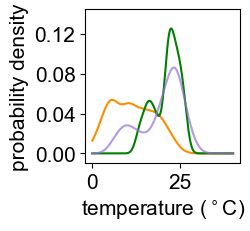

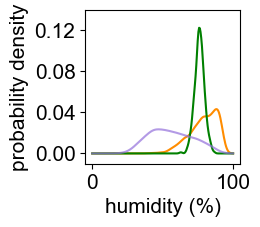

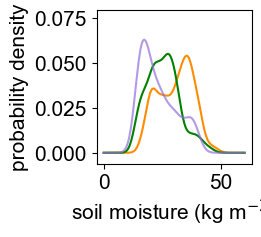

In [54]:
from scipy.stats import gaussian_kde
env_strains_list=["JU1249","EG4725","MY16","ED3017","MY23","JT11398", "CB4856","DL238","JU775","JU258", "CX11314","LKC34"]
#env_strains=['N2','JU1249','EG4725','MY16','MY23','ED3017','JT11398',   'JU775','JU258','DL238','CB4856','LKC34','CX11314']
env_label_index=[]
for i,strain in enumerate(env_strains_list):
    env_label_index.append(strains.index(strain)-1)

bins = np.linspace(0,40,200)
#darkgoldenrod
plt.figure(figsize=(2,2))
bins = np.linspace(0,40,200)
plt.plot(bins, gaussian_kde(temp_strains[:,env_label_index[0:6]].flatten())(bins), label='temperate', c='darkorange')
plt.plot(bins, gaussian_kde(temp_strains[:,env_label_index[6:-2]].flatten())(bins), label='sub/tropic', c='green')
plt.plot(bins, gaussian_kde(temp_strains[:,env_label_index[-2:]].flatten())(bins), label='others', c='mediumpurple', alpha=0.7)
#plt.legend(fontsize=9, loc=(1.01,0))
plt.xticks(fontsize=15)
plt.yticks(np.arange(0,0.16,0.04), fontsize=15)
plt.ylim(-0.01,0.145)
plt.xlabel('temperature ($^\circ$C)', fontsize=15)
plt.ylabel('probability density', fontsize=15)
#plt.savefig('/Users/ykang/Desktop/temp_three_groups.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(2,2))
bins = np.linspace(0,100,200)
plt.plot(bins, gaussian_kde(humid_strains[:,env_label_index[0:6]].flatten())(bins), label='temperate', c='darkorange')
plt.plot(bins, gaussian_kde(humid_strains[:,env_label_index[6:-2]].flatten())(bins), label='sub/tropic', c='green')
plt.plot(bins, gaussian_kde(humid_strains[:,env_label_index[-2:]].flatten())(bins), label='others', c='mediumpurple', alpha=0.7)
#plt.legend(fontsize=9, loc=(1.01,0))
plt.xticks(fontsize=15)
plt.yticks(np.arange(0,0.14,0.04), fontsize=15)
plt.ylim(-0.01,0.14)
plt.xlabel('humidity (%)', fontsize=15)
plt.ylabel('probability density', fontsize=15)
#plt.savefig('/Users/ykang/Desktop/humid_three_groups.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(2,2))
bins = np.linspace(0,60,200)
plt.plot(bins, gaussian_kde(moist_strains[:,env_label_index[0:7]].flatten())(bins), label='temperate', c='darkorange')
plt.plot(bins, gaussian_kde(moist_strains[:,env_label_index[7:-2]].flatten())(bins), label='sub/tropic', c='green')
plt.plot(bins, gaussian_kde(moist_strains[:,env_label_index[-2:]].flatten())(bins), label='dry', c='mediumpurple', alpha=0.7)
#plt.legend(fontsize=14, loc=(1.01,0))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(-0.006,0.08)
plt.xlabel('soil moisture (kg m$^{-2}$)', fontsize=15)
plt.ylabel('probability density', fontsize=15)
#plt.savefig('/Users/ykang/Desktop/moist_three_groups.pdf', bbox_inches='tight')
plt.show()

___
## Plot genetic covariance component of mean aggregation & timescale

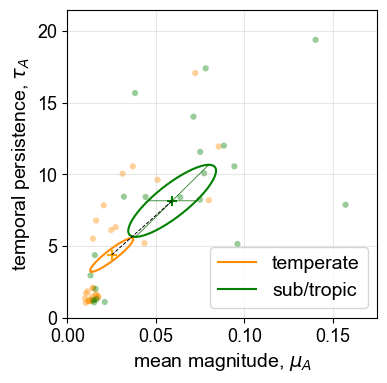

In [55]:
env_strains_list=["JU1249","EG4725","MY16","ED3017","MY23","JT11398", "CB4856","DL238","JU775","JU258", "CX11314","LKC34"]

env_label_index=[]
for i,strain in enumerate(env_strains_list):
    env_label_index.append(strains.index(strain))

plt.figure(figsize=(4,4))
plt.xlabel('mean magnitude, $\\mu_{A}$')
plt.ylabel('temporal persistence, $\\tau_{A}$')
plt.grid(ls='-', alpha=0.3)

env1_mean_agg=[]
env1_dynamics=[]
for i in env_label_index[0:6]:  #0:7
    plt.scatter(x[strain_labels==i], y[strain_labels==i], color='darkorange', s=20, alpha=0.4, edgecolors='none')
    env1_mean_agg.append(x[strain_labels==i])
    env1_dynamics.append(y[strain_labels==i])
cov_env1 = np.array(pd.read_csv("/Users/ykang/YJ_Antonio/env_data/COV_temperate_noN2.csv")) #"/Users/ykang/YJ_Antonio/env_data/COV_env1.csv"
eigenvalues, eigenvectors = np.linalg.eig(cov_env1)
theta = np.linspace(0, 2*np.pi, 1000)
ellipsis = (np.sqrt(abs(eigenvalues)[None,:])*eigenvectors)@[np.sin(theta), np.cos(theta)]
plt.plot(ellipsis[0,:]+np.hstack(env1_mean_agg).mean(), ellipsis[1,:]+np.hstack(env1_dynamics).mean(), color='darkorange', label='temperate')

env2_mean_agg=[]
env2_dynamics=[]
for i in env_label_index[6:-2]:  #7:-1
    plt.scatter(x[strain_labels==i], y[strain_labels==i], color='green', s=20, alpha=0.4, edgecolors='none')
    env2_mean_agg.append(x[strain_labels==i])
    env2_dynamics.append(y[strain_labels==i])
cov_env2 = np.array(pd.read_csv("/Users/ykang/YJ_Antonio/env_data/COV_tropic.csv")) #"/Users/ykang/YJ_Antonio/env_data/COV_env2_noCX11314.csv"
eigenvalues, eigenvectors = np.linalg.eig(cov_env2)
theta = np.linspace(0, 2*np.pi, 1000)
ellipsis = (np.sqrt(abs(eigenvalues)[None,:])*eigenvectors)@[np.sin(theta), np.cos(theta)]
plt.plot(ellipsis[0,:]+np.hstack(env2_mean_agg).mean(), ellipsis[1,:]+np.hstack(env2_dynamics).mean(), color='green', label='sub/tropic')

for i in range(2):
    plt.plot([np.hstack(env2_mean_agg).mean(), np.sqrt(abs(eigenvalues))[i]*eigenvectors[0, i]+np.hstack(env2_mean_agg).mean()], 
        [np.hstack(env2_dynamics).mean(), np.sqrt(abs(eigenvalues))[i]*eigenvectors[1, i]+np.hstack(env2_dynamics).mean()], 
         color='darkgreen', linewidth=0.5, alpha=1)
    plt.plot([np.hstack(env2_mean_agg).mean(), -np.sqrt(abs(eigenvalues))[i]*eigenvectors[0, i]+np.hstack(env2_mean_agg).mean()], 
        [np.hstack(env2_dynamics).mean(), -np.sqrt(abs(eigenvalues))[i]*eigenvectors[1, i]+np.hstack(env2_dynamics).mean()], 
         color='darkgreen', linewidth=0.5, alpha=1)

plt.scatter( np.hstack(env1_mean_agg).mean(), np.hstack(env1_dynamics).mean() , color='orange', s=60, marker='+')
plt.scatter( np.hstack(env2_mean_agg).mean(), np.hstack(env2_dynamics).mean() , color='green', s=60, marker='+')
plt.plot([np.hstack(env1_mean_agg).mean(), np.hstack(env2_mean_agg).mean()],
         [np.hstack(env1_dynamics).mean(), np.hstack(env2_dynamics).mean()],'k--', linewidth=0.7)
plt.legend(loc='lower right')
plt.ylim(0,21.5)
plt.xlim(0,0.175)
#plt.savefig('/Users/ykang/Desktop/agg_G_mat.pdf', bbox_inches='tight')
plt.show()

___
## Statistical test of climate group difference

/opt/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/opt/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


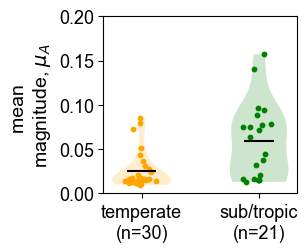

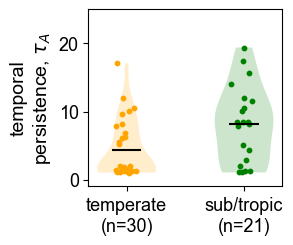

In [56]:
plt.figure(figsize=(2.5,2.3))
violin_list=[np.hstack(env1_mean_agg), np.hstack(env2_mean_agg)]
parts=plt.violinplot(violin_list, positions=[0,1], showmeans=True, showmedians=False, showextrema=False)
for pc, color in zip(parts['bodies'], ['orange','green']):
    pc.set_facecolor(color)
    pc.set_alpha(0.2)
parts['cmeans'].set_color('k')
plt.scatter(np.random.normal(0,.05,len(np.hstack(env1_mean_agg))),np.hstack(env1_mean_agg), s=10, c='orange') #c=strain_labels[strain_labels<7], cmap='Greens')#, label=[strains[i] i in strain_labels[strain_labels<7] ])
plt.scatter(np.random.normal(1,.05,len(np.hstack(env2_mean_agg))),np.hstack(env2_mean_agg), s=10, c='green') #c=2*(strain_labels[(7<=strain_labels)&(strain_labels<11)]-7), cmap='autumn')#, label=[strains[i] for i in strain_labels[(7<=strain_labels)&(strain_labels<11)] ])
plt.clim(-2,8)
plt.xticks([0,1],['temperate\n(n=30)','sub/tropic\n(n=21)'])
plt.ylabel('mean \nmagnitude, $\\mu_{A}$')
plt.ylim(0,0.2)
#plt.savefig('/Users/ykang/Desktop/climate_group_violin_agg.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(2.5,2.3))
violin_list=[np.hstack(env1_dynamics), np.hstack(env2_dynamics)]
parts=plt.violinplot(violin_list, positions=[0,1], showmeans=True, showmedians=False, showextrema=False)
for pc, color in zip(parts['bodies'], ['orange','green']):
    pc.set_facecolor(color)
    pc.set_alpha(0.2)
parts['cmeans'].set_color('k')
plt.scatter(np.random.normal(0,.05,len(np.hstack(env1_dynamics))),np.hstack(env1_dynamics), s=10, c='orange') #c=strain_labels[strain_labels<7], cmap='Greens')
plt.scatter(np.random.normal(1,.05,len(np.hstack(env2_dynamics))),np.hstack(env2_dynamics), s=10, c='green') #c=2*(strain_labels[(7<=strain_labels)&(strain_labels<11)]-7), cmap='autumn')
plt.clim(-2,8)
plt.xticks([0,1],['temperate\n(n=30)','sub/tropic\n(n=21)'])
plt.ylabel('temporal\npersistence, $\\tau_{A}$')
plt.ylim(-1,25)
#plt.savefig('/Users/ykang/Desktop/climate_group_violin_timescale.pdf', bbox_inches='tight')
plt.show()

### subgroup(strain) not accounted: Kruskal-Wallis

In [57]:
from scipy import stats
print( stats.kruskal(np.hstack(env1_mean_agg), np.hstack(env2_mean_agg)) )
print( stats.kruskal(np.hstack(env1_dynamics), np.hstack(env2_dynamics)) )

KruskalResult(statistic=11.475824175824187, pvalue=0.0007050737281086994)
KruskalResult(statistic=5.452014652014668, pvalue=0.019545773905331264)


### subgroup(strain) accounted : Permutation test on ranks

In [58]:
kD=2   #density 0=10, 1=20, 2=30
mean_agg = np.hstack([daggs_tavg_strain[ks].mean(axis=1) for ks in range(len(strains))])
agg_timescale = np.hstack([[np.cumsum(acfs_strains[ks][kexp]).max() for kexp in range(len(acfs_strains[ks]))] for ks in range(len(strains))])
labels = np.hstack([np.ones(len(acfs_strains[ks]))*ks for ks in range(len(strains))])
strain_names = np.array([ strains[int(labels[i])] for i in range(len(labels))])

import pandas as pd
mean_agg_df = pd.DataFrame({'Strain':strain_names, 'Value':mean_agg})
print(mean_agg_df)
agg_timescale_df = pd.DataFrame({'Strain':strain_names, 'Value':agg_timescale})
print(agg_timescale_df)

   Strain     Value
0      N2  0.030913
1      N2  0.021636
2      N2  0.028756
3      N2  0.018543
4      N2  0.015224
..    ...       ...
62  JU258  0.015572
63  JU258  0.016007
64  JU258  0.016498
65  JU258  0.013111
66  JU258  0.038280

[67 rows x 2 columns]
   Strain      Value
0      N2  11.231807
1      N2   2.538037
2      N2   1.843523
3      N2   1.598426
4      N2   2.231652
..    ...        ...
62  JU258   4.373000
63  JU258   2.012890
64  JU258   1.293285
65  JU258   2.951896
66  JU258  15.685336

[67 rows x 2 columns]


In [60]:
groups = np.hstack((np.repeat(["temperate"], np.hstack(env1_mean_agg).shape[0]), 
                    np.repeat(["tropic"], np.hstack(env2_mean_agg).shape[0])))

#exclude N2
GLMM_mean_agg=pd.concat([mean_agg_df[mean_agg_df['Strain'].isin(env_strains_list[0:6])],
                        mean_agg_df[mean_agg_df['Strain'].isin(env_strains_list[6:-2])]])
GLMM_mean_agg['Group']=groups
#GLMM_mean_agg

GLMM_agg_timescale=pd.concat([agg_timescale_df[agg_timescale_df['Strain'].isin(env_strains_list[0:6])],
                        agg_timescale_df[agg_timescale_df['Strain'].isin(env_strains_list[6:-2])]])
GLMM_agg_timescale['Group']=groups
#GLMM_agg_timescale

In [61]:
# Rank-transform the values (non-parametric approach)
from scipy.stats import rankdata
GLMM_mean_agg["Rank"] = rankdata(GLMM_mean_agg["Value"])
#GLMM_mean_agg
GLMM_agg_timescale["Rank"] = rankdata(GLMM_agg_timescale["Value"])
#GLMM_agg_timescale

In [62]:
# Compute observed mean Rank diff
obs_diff_Y1 = GLMM_mean_agg.groupby("Group")["Rank"].mean().diff().iloc[-1]
obs_diff_Y2 = GLMM_agg_timescale.groupby("Group")["Rank"].mean().diff().iloc[-1]

# Permutation test
n_perm = 2000
perm_dists_Y1 = []
perm_dists_Y2 = []
subgroups = GLMM_mean_agg["Strain"].unique()

np.random.seed(105)
for _ in tqdm( range(n_perm) ):
    Y1_perm = GLMM_mean_agg.copy()
    Y2_perm = GLMM_agg_timescale.copy()
    
    # Randomly shuffle SubGroups = accounting for subgroup dependency.
    Y1_perm = Y1_perm.set_index("Strain").loc[np.random.permutation(subgroups)].reset_index()
    Y1_perm["Group"] = ["temperate"]*len(Y1_perm.set_index("Strain").loc[Y1_perm["Strain"].unique()[0:6]]) + ["tropic"]*len(Y1_perm.set_index("Strain").loc[Y1_perm["Strain"].unique()[6:]])
    Y2_perm = Y2_perm.set_index("Strain").loc[np.random.permutation(subgroups)].reset_index()
    Y2_perm["Group"] = ["temperate"]*len(Y2_perm.set_index("Strain").loc[Y2_perm["Strain"].unique()[0:6]]) + ["tropic"]*len(Y2_perm.set_index("Strain").loc[Y2_perm["Strain"].unique()[6:]])
    
    # Compute new mean Value diff
    perm_diff_Y1 = Y1_perm.groupby("Group")["Rank"].mean().diff().iloc[-1]
    perm_diff_Y2 = Y2_perm.groupby("Group")["Rank"].mean().diff().iloc[-1]
    
    perm_dists_Y1.append(perm_diff_Y1)
    perm_dists_Y2.append(perm_diff_Y2)

# Compute p-value (proportion of shuffled distance greater than or equal to observed)
p_value_Y1 = np.mean(np.array(perm_dists_Y1) >= obs_diff_Y1)
p_value_Y2 = np.mean(np.array(perm_dists_Y1) >= obs_diff_Y2)
print(f"Permutation Test p-value: {p_value_Y1}, {p_value_Y2}")
plt.show()

  0%|          | 0/2000 [00:00<?, ?it/s]

Permutation Test p-value: 0.039, 0.108


### Permutation Test for Multivariate Ranks

  0%|          | 0/2000 [00:00<?, ?it/s]

Multivariate Permutation Test p-value: 0.0485
observed Euclidean distance between group mean ranks: D = 17.40250262191243


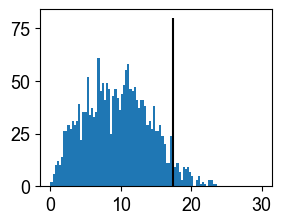

In [63]:
# Compute observed mean rank diff
obs_diff_Y1 = GLMM_mean_agg.groupby("Group")["Rank"].mean().diff().iloc[-1]
obs_diff_Y2 = GLMM_agg_timescale.groupby("Group")["Rank"].mean().diff().iloc[-1]

# Compute squared Euclidean distance for observed rank diffs
obs_dist = np.sqrt(obs_diff_Y1**2 + obs_diff_Y2**2)

# Permutation test
n_perm = 2000
perm_dists = []
subgroups = GLMM_mean_agg["Strain"].unique()

np.random.seed(135)
for _ in tqdm( range(n_perm) ):
    Y1_perm = GLMM_mean_agg.copy()
    Y2_perm = GLMM_agg_timescale.copy()
    
    # Randomly shuffle SubGroups = accounting for subgroup dependency.
    Y1_perm = Y1_perm.set_index("Strain").loc[np.random.permutation(subgroups)].reset_index()
    Y1_perm["Group"] = ["temperate"]*len(Y1_perm.set_index("Strain").loc[Y1_perm["Strain"].unique()[0:6]]) + ["tropic"]*len(Y1_perm.set_index("Strain").loc[Y1_perm["Strain"].unique()[6:]])
    Y2_perm = Y2_perm.set_index("Strain").loc[np.random.permutation(subgroups)].reset_index()
    Y2_perm["Group"] = ["temperate"]*len(Y2_perm.set_index("Strain").loc[Y2_perm["Strain"].unique()[0:6]]) + ["tropic"]*len(Y2_perm.set_index("Strain").loc[Y2_perm["Strain"].unique()[6:]])
    
    # Compute new mean rank diff
    perm_diff_Y1 = Y1_perm.groupby("Group")["Rank"].mean().diff().iloc[-1]
    perm_diff_Y2 = Y2_perm.groupby("Group")["Rank"].mean().diff().iloc[-1]
    
    # Compute squared Euclidean distance for permutation
    perm_dist = np.sqrt(perm_diff_Y1**2 + perm_diff_Y2**2)
    perm_dists.append(perm_dist)

# Compute p-value (proportion of shuffled distance greater than or equal to observed)
p_value = np.mean(np.array(perm_dists) >= obs_dist)
print(f"Multivariate Permutation Test p-value: {p_value}")
print(f"observed Euclidean distance between group mean ranks: D = {obs_dist}")
plt.figure(figsize=(3,2.3))
plt.hist(perm_dists, bins=np.linspace(0,30,100))
plt.vlines(x=obs_dist, ymin=0, ymax=80, color='black')
#plt.ylim(0,50)
plt.show()

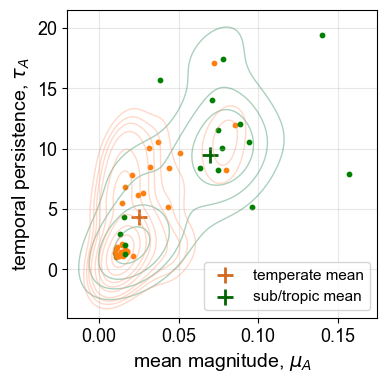

In [64]:
env_strains_list=["JU1249","EG4725","MY16","ED3017","MY23","JT11398", "CB4856","DL238","JU775","JU258", "CX11314","LKC34"]

env_label_index=[]
for i,strain in enumerate(env_strains_list):
    env_label_index.append(strains.index(strain))
    
import seaborn as sns
plt.figure(figsize=(4,4))
plt.xlabel('mean magnitude, $\\mu_{A}$')
plt.ylabel('temporal persistence, $\\tau_{A}$')
plt.grid(ls='-', alpha=0.3)
#darkseagreen
g = sns.kdeplot(data=GLMM_mean_agg.merge(GLMM_agg_timescale, left_on=('Strain','Group'), right_on=('Strain','Group')), 
        x="Value_x", y="Value_y", palette=('seagreen','lightsalmon'), hue_order=('tropic','temperate'),
        hue="Group", fill=False, alpha=0.4, thresh=0.17, linewidths=1)#thresh=0.16,levels=16,
g.set(title='', xlabel='mean magnitude, $\\mu_{A}$', ylabel='temporal persistence, $\\tau_{A}$')#,xlim=(0),ylim=(0))

env1_mean_agg=[]
env1_dynamics=[]
for i in env_label_index[0:7]:  #0:7
    plt.scatter(x[strain_labels==i], y[strain_labels==i], color='C1', s=10, alpha=1)
    env1_mean_agg.append(x[strain_labels==i])
    env1_dynamics.append(y[strain_labels==i])

env2_mean_agg=[]
env2_dynamics=[]
for i in env_label_index[7:-2]:  #7:-1
    plt.scatter(x[strain_labels==i], y[strain_labels==i], color='green', s=10, alpha=1)
    env2_mean_agg.append(x[strain_labels==i])
    env2_dynamics.append(y[strain_labels==i])

plt.scatter( np.hstack(env1_mean_agg).mean(), np.hstack(env1_dynamics).mean() , color='chocolate', s=130, marker='+',linewidths=2, label='temperate mean')
plt.scatter( np.hstack(env2_mean_agg).mean(), np.hstack(env2_dynamics).mean() , color='darkgreen', s=130, marker='+',linewidths=2, label='sub/tropic mean')
plt.legend(loc='lower right', fontsize=11)
plt.ylim(-4,21.5)
plt.xlim(-0.02,0.175)
#plt.savefig('/Users/ykang/Desktop/contour2d_agg_timescale.pdf', bbox_inches='tight')
plt.show()

___
## Plot heritability

In [65]:
herit_agg = pd.read_csv("/Users/ykang/YJ_writing/Evo_Agg_paper/dataset/heritability_result/herit_mean_agg.csv")
herit_timescale = pd.read_csv("/Users/ykang/YJ_writing/Evo_Agg_paper/dataset/heritability_result/herit_agg_timescale.csv")
herit_timescale

,type,H2,ci_l,ci_r,phenotype
0,broad-sense,0.331178,0.000000,0.422710,agg_timescale
1,narrow-sense,0.200338,0.032998,0.277762,agg_timescale


In [67]:
herit_shuffled_agg = pd.read_csv("/Users/ykang/YJ_writing/Evo_Agg_paper/dataset/heritability_result/herit_mean_agg_shuffled.csv")
herit_shuffled_timescale = pd.read_csv("/Users/ykang/YJ_writing/Evo_Agg_paper/dataset/heritability_result/herit_agg_timescale_shuffled.csv")

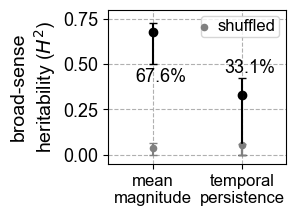

In [68]:
plt.figure(figsize=(2.3,2))
plt.scatter([0,1], [herit_agg.iloc[0,1], herit_timescale.iloc[0,1]], color='k')
plt.scatter([0,1], [herit_shuffled_agg.iloc[0,1], herit_shuffled_timescale.iloc[0,1]], color='grey', label='shuffled', s=20)
plt.legend(loc=(0.52,0.82),borderpad=0.2, handlelength=0, fontsize=12)
plt.text(0-0.2,0.4,'67.6%')
plt.text(1-0.2,0.45,'33.1%')
plt.errorbar(x=[0,1], y=[herit_agg.iloc[0,1], herit_timescale.iloc[0,1]], 
             yerr=[ [herit_agg.iloc[0,1]-herit_agg.iloc[0,2],herit_timescale.iloc[0,1]-herit_timescale.iloc[0,2]], [herit_agg.iloc[0,3]-herit_agg.iloc[0,1], herit_timescale.iloc[0,3]-herit_timescale.iloc[0,1]] ], 
             capsize=3, ecolor = "black", linestyle="")
plt.errorbar(x=[0,1], y=[herit_shuffled_agg.iloc[0,1], herit_shuffled_timescale.iloc[0,1]], 
             yerr=[ [herit_shuffled_agg.iloc[0,1]-herit_shuffled_agg.iloc[0,2],herit_shuffled_timescale.iloc[0,1]-herit_shuffled_timescale.iloc[0,2]], [herit_shuffled_agg.iloc[0,3]-herit_shuffled_agg.iloc[0,1], herit_shuffled_timescale.iloc[0,3]-herit_shuffled_timescale.iloc[0,1]] ], 
             capsize=3, ecolor = "grey", linestyle="")
plt.ylim(-0.05,0.8)
plt.ylabel('broad-sense\nheritability ($H^2$)')
plt.xlim(-0.5,1.5)
plt.xticks([0,1],['mean\nmagnitude','temporal\npersistence'],rotation=0, ha='center', fontsize=12)
plt.grid(linestyle="--")
#plt.savefig('/Users/ykang/Desktop/broad_herit.pdf', bbox_inches='tight')
plt.show()

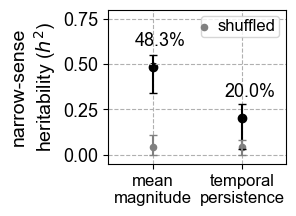

In [69]:
plt.figure(figsize=(2.3,2))
plt.scatter([0,1], [herit_agg.iloc[1,1], herit_timescale.iloc[1,1]], color='k')
plt.scatter([0,1], [herit_shuffled_agg.iloc[1,1], herit_shuffled_timescale.iloc[1,1]], color='grey', label='shuffled', s=20)
plt.legend(loc=(0.52,0.82),borderpad=0.2, handlelength=0, fontsize=12)
plt.text(0-0.2,0.6,'48.3%')
plt.text(1-0.2,0.32,'20.0%')
plt.errorbar(x=[0,1], y=[herit_agg.iloc[1,1], herit_timescale.iloc[1,1]], 
             yerr=[ [herit_agg.iloc[1,1]-herit_agg.iloc[1,2],herit_timescale.iloc[1,1]-herit_timescale.iloc[1,2]], [herit_agg.iloc[1,3]-herit_agg.iloc[1,1], herit_timescale.iloc[1,3]-herit_timescale.iloc[1,1]] ], 
             capsize=3, ecolor = "black", linestyle="")
plt.errorbar(x=[0,1], y=[herit_shuffled_agg.iloc[1,1], herit_shuffled_timescale.iloc[1,1]], 
             yerr=[ [herit_shuffled_agg.iloc[1,1]-herit_shuffled_agg.iloc[1,2],herit_shuffled_timescale.iloc[1,1]-herit_shuffled_timescale.iloc[1,2]], [herit_shuffled_agg.iloc[1,3]-herit_shuffled_agg.iloc[1,1], herit_shuffled_timescale.iloc[1,3]-herit_shuffled_timescale.iloc[1,1]] ], 
             capsize=3, ecolor = "grey", linestyle="")
plt.ylim(-0.05,0.8)
plt.ylabel('narrow-sense\nheritability ($h^2$)')
plt.xlim(-0.5,1.5)
plt.xticks([0,1],['mean\nmagnitude','temporal\npersistence'],rotation=0, ha='center', fontsize=12)
plt.grid(linestyle="--")
#plt.savefig('/Users/ykang/Desktop/narrow_herit.pdf', bbox_inches='tight')
plt.show()